In [2]:
import sys
sys.path.append("../src")

import logging
from pathlib import Path
import numpy as np
import torch
from natsort import natsorted
from torch import nn
from matplotlib import pyplot as plt
from dataset.data_loading import BasicDataset
from dataset.dataset_interface import DatasetInterface
from networks.UNet.unet_model import UNet
import open3d as o3d
from utils.visualization_utils import visualize_depth, to_rgb
from utils.transformation_utils import imgs_to_pcd, rs_ci, unnormalize_depth
import yaml

root_path = Path("../")

class Args:
    model_dir = root_path / "local_resources/models/1645702073.1762455/M_total"

args = Args()

config_path = args.model_dir.parent / "config.yml"
model = natsorted(args.model_dir.glob("*.pth"), key=lambda f: f.stem.split('e')[1])[-1]
with open(config_path) as f:
    config = yaml.safe_load(f)

network_config = config['network_config']
trainer_config = config['basic_trainer']
dataset_config_yaml = config['dataset_config']
dataset_config = BasicDataset.Config.from_config(dataset_config_yaml)

path = root_path / Path(trainer_config['train_path']).parent / "test_dataset.json"
files = DatasetInterface.get_files_by_path(path)

net = UNet(
    n_input_channels=dataset_config.num_in_channels(),
    n_output_channels=1, 
    initial_channels=network_config['initial_channels'],
    bilinear=network_config['bilinear']
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
logging.info(f'Loading model {model}')
logging.info(f'Using device {device}')

net.to(device=device)
net.load_state_dict(torch.load(model, map_location=device))
# fixes wrongly saved weights from data parallel
# tmp_net = nn.DataParallel(net)
# tmp_net.load_state_dict(torch.load(model, map_location=device))
# model.unlink()
# torch.save(tmp_net.module.state_dict(), model)
# net.load_state_dict(torch.load(model, map_location=device))
net.eval()

logging.info('Model loaded!')

INFO - 2022-02-24 20:12:11,818 - 287483507 - Loading model ../local_resources/models/1645702073.1762455/M_total/e50.pth
INFO - 2022-02-24 20:12:11,819 - 287483507 - Using device cpu
INFO - 2022-02-24 20:12:11,833 - 287483507 - Model loaded!


INFO - 2022-02-24 20:22:18,870 - 3918668833 - 
Predicting image /home/claudiusk/Documents/Studium/KIT/Master/Semester_1/DL_Praktikum/self-supervised-depth-denoising/resources/images/calibrated_masked_rg/not-cropped/ycb_video/10022022/1644490692.6490428.npz ...


178.01239
Mean depths: Input 895.154541015625 Label 894.089111328125 Predicted 892.6008911132812
Distance IT 14.322367833209233
Distance OT 13.486058575328865


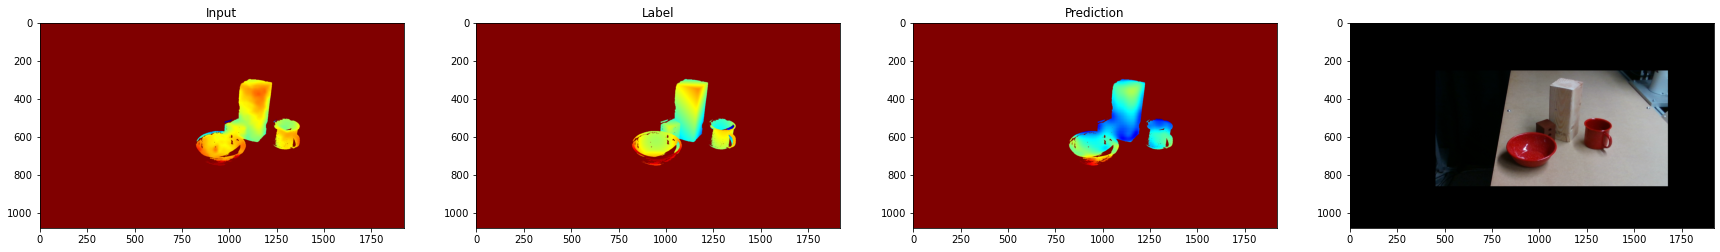

In [6]:
idx = np.random.randint(len(files), size=1).item()
rs_rgb, rs_depth, zv_rgb, zv_depth, mask = DatasetInterface.load(files[idx])

logging.info(f'\nPredicting image {files[idx]} ...')

rs_min = np.nanmin(rs_depth)
rs_max = np.nanmax(rs_depth)

set = BasicDataset.preprocess_set(
    rs_rgb, 
    rs_depth, 
    mask, 
    zv_depth, 
    dataset_config
)

img = set['image'].unsqueeze(0)
nan_mask = set['nan-mask'].squeeze().numpy()
region_mask = set['region-mask'].squeeze().numpy()
img = img.to(device=device, dtype=torch.float32)

with torch.no_grad() and torch.cuda.amp.autocast(enabled=network_config['amp']):
    pred_depths = net(img)
    pred_depth = pred_depths.squeeze().float().cpu().detach().numpy()

# resize images to prediction size
input_rgb = BasicDataset.resize(rs_rgb, dataset_config.scale)
# input_depth = BasicDataset.resize(rs_depth, dataset_config.scale)
input_depth = img.numpy().squeeze()[3]
# real_depth = BasicDataset.resize(zv_depth, dataset_config.scale)
real_depth = set['label'].numpy().squeeze()
output_rgb = BasicDataset.resize(zv_rgb, dataset_config.scale)

# undo normalization
if dataset_config.normalize_depths:
    input_depth = unnormalize_depth(input_depth, dataset_config.normalize_depths_min, dataset_config.normalize_depths_max)
    pred_depth = unnormalize_depth(pred_depth, dataset_config.normalize_depths_min, dataset_config.normalize_depths_max)
    real_depth = unnormalize_depth(real_depth, dataset_config.normalize_depths_min, dataset_config.normalize_depths_max)

# blackout pixel not in mask
mask = np.logical_and(nan_mask, region_mask)
pred_depth = np.where(mask, pred_depth, np.nan)
input_depth = np.where(mask, input_depth, np.nan)
real_depth = np.where(mask, real_depth, np.nan)

print(np.nanmax(np.abs(input_depth - real_depth)))

print(f"Mean depths: Input {np.nanmean(input_depth)} Label {np.nanmean(real_depth)} Predicted {np.nanmean(pred_depth)}")
print(f"Distance IT {np.nansum(np.abs(input_depth - real_depth))/ np.sum(mask)}")
print(f"Distance OT {np.nansum(np.abs(pred_depth - real_depth)) / np.sum(mask)}")

pred_pcd = imgs_to_pcd(input_rgb, pred_depth, rs_ci)
input_pcd = imgs_to_pcd(input_rgb, input_depth.astype(np.float32), rs_ci)
output_pcd = imgs_to_pcd(output_rgb, real_depth, rs_ci)

o3d.visualization.draw_geometries([input_pcd])
o3d.visualization.draw_geometries([output_pcd])
o3d.visualization.draw_geometries([pred_pcd])
o3d.visualization.draw_geometries([input_pcd, output_pcd])
o3d.visualization.draw_geometries([input_pcd, pred_pcd])
o3d.visualization.draw_geometries([pred_pcd, output_pcd])

_, axarr = plt.subplots(1, 4, figsize=(30, 10))
axarr[0].title.set_text("Input")
axarr[0].imshow(visualize_depth(input_depth))
axarr[1].title.set_text("Label")
axarr[1].imshow(visualize_depth(real_depth))
axarr[2].title.set_text("Prediction")
axarr[2].imshow(visualize_depth(pred_depth))
axarr[3].imshow(to_rgb(rs_rgb))